# <center>Expand Your Reach: A Data Analysis of Google's App Store for Creating and Positioning a New App</center>

<img src="https://i.ibb.co/SmQq4cZ/the-average-tech-guy-Dsm-Dqi-Ydua-U-unsplash-1.jpg" />

## Table of Contents:

* [1. Discovery (identificazione del problema e degli obiettivi)](#first-bullet)
    * [1.1 Linee guida del progetto](#first1-bullet)
* [2. Data Cleaning & Data Transformation](#second-bullet)
* [3. Exploratory data analysis (EDA)](#third-bullet)
* [4. Machine Learning](#fourth-bullet)
    * [4.1 Encoding variabili categoriche](#fourth1-bullet)
    * [4.2 Modello Gradient Boosting](#fourth2-bullet)
    * [4.3 Feature Importances](#fourth3-bullet)
* [5. Conclusioni](#fifth-bullet)
    * [5.1 Conclusioni linee guida](#fifth1-bullet)
    * [5.2 Ipotesi lancio nuova App](#fifth2-bullet)

## 1. Discovery (identificazione del problema e degli obiettivi) <a class="anchor" id="first-bullet"></a>

Partendo da questo dataset che rappresenta i dati dell'app store di Google, lo scopo del progetto è quello di analizzare a fondo il dataset, esplorando i vari campi, correlazioni e immaginando di dover creare una nuova app scegliere una strategia per inserirla sul mercato.

In [198]:
#importo le librerie che servono
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import warnings
from scipy.stats import f_oneway
from sklearn.model_selection import learning_curve,GridSearchCV, train_test_split
from sklearn.metrics import r2_score,mean_squared_error,make_scorer
from sklearn.ensemble import GradientBoostingRegressor
from category_encoders import LeaveOneOutEncoder
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows', None)

In [199]:
#importo il dataset
df = pd.read_csv("googleplaystore.csv")

In [200]:
df.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.10,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.90,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.70,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.50,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.30,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


Il dataset contiene le seguenti colonne:

**App:** Rappresenta il nome dell'app  
**Category:** Rappresenta la categoria dell'app  
**Rating:** Il punteggio che viene dato ad ogni app dagli utenti  
**Reviews:** Il numero di recensioni ricevute dall'app  
**Size:** Dimensione dell'app  
**Installs:** Numero di installazioni dell'app  
**Type:** Se app gratuita o a pagamento  
**Price:** Prezzo dell'app  
**Content Rating:** A che categoria è rivolta l'app  
**Genres:** Genere dell'app  
**Last Updated:** Data ultimo aggiornamento  
**Current Ver:** Versione dell'app  
**Android Ver:** Versione di Android su cui l'app funziona  

In [201]:
#controllo le info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


Dando un'occhiata alle info mi accorgo subito che ci sono delle colonne che dovrebbero essere numeriche ma che invece sono di tipo 'object', quali: *'Reviews', 'Size', 'Installs', 'Price'*. Last Updated è invece una data che vedrò dopo come trattare.

In [202]:
#controllo numero righe e colonne
df.shape

(10841, 13)

### 1.1 Linee guida del progetto <a class="anchor" id="first1-bullet"></a>
Per creare un percorso al progetto mi pongo delle domande in modo da avere dei mini-obiettivi da raggiungere a cui dare una risposta tramite l'analisi dati:
* **Quali sono le categorie (e generi) di App più rappresentate nell'App Store di Google? E quelle col Rating più alto?**
* **App gratuita o a pagamento?**
* **Prezzo e dimensione dell'App influiscono sul Rating?**
* **Esiste un periodo migliore o peggiore per lanciare un'App (mese,anno)?**
* **A che categoria è meglio rivolgere un'App?**  
* **È possibile prevedere il Rating di un'app?**
* **Quali sono le variabili che determinano di più un Rating alto?**

## 2. Data Cleaning & Data Transformation <a class="anchor" id="second-bullet"></a>

In [203]:
#check di eventuali valori nulli
df.isnull().sum()

App                  0
Category             0
Rating            1474
Reviews              0
Size                 0
Installs             0
Type                 1
Price                0
Content Rating       1
Genres               0
Last Updated         0
Current Ver          8
Android Ver          3
dtype: int64

Dando un'occhiata a questo risultato saltano all'occhio i 1474 valori nulli di "Rating" che su 11000 righe circa sarebbe un po' troppo eliminarle tutte, quindi vedrò come trattarli per mantenere più dati possibili.

In [204]:
#controllo qual è l'unica riga in cui Type è NaN
nan_type_rows = df[df['Type'].isna()]

print(nan_type_rows)

                            App Category  Rating Reviews                Size  \
9148  Command & Conquer: Rivals   FAMILY     NaN       0  Varies with device   

     Installs Type Price Content Rating    Genres   Last Updated  \
9148        0  NaN     0   Everyone 10+  Strategy  June 28, 2018   

             Current Ver         Android Ver  
9148  Varies with device  Varies with device  


Nella riga ottenuta oltre al NaN di "Type", anche il "Rating" è NaN e altri valori sono 'Varies with device', decido quindi di eliminarla completamente per troppe poche informazioni.

In [205]:
df.drop(9148,inplace=True)

In [206]:
#controllo i valori unici della colonna 'Installs'
df['Installs'].unique()

array(['10,000+', '500,000+', '5,000,000+', '50,000,000+', '100,000+',
       '50,000+', '1,000,000+', '10,000,000+', '5,000+', '100,000,000+',
       '1,000,000,000+', '1,000+', '500,000,000+', '50+', '100+', '500+',
       '10+', '1+', '5+', '0+', 'Free'], dtype=object)

In [207]:
#controllo i casi in cui la colonna 'Installs' ha come valore unico 'Free'
installs_free = df[df['Installs'] == 'Free']
print(installs_free)

                                           App Category  Rating Reviews  \
10472  Life Made WI-Fi Touchscreen Photo Frame      1.9   19.00    3.0M   

         Size Installs Type     Price Content Rating             Genres  \
10472  1,000+     Free    0  Everyone            NaN  February 11, 2018   

      Last Updated Current Ver Android Ver  
10472       1.0.19  4.0 and up         NaN  


Praticamente alla riga 10472 c'è un errore, perchè ogni colonna è spostata di uno e manca la Categoria, la sistemo nella cella seguente.

In [208]:
#sposto di un posto verso destra tutti i valori delle colonne
df.loc[10472] = df.loc[10472].shift()

#sistemo rimettendo al giusto posto il nome dell'App e aggiungendo Categoria e Genere tramite una ricerca
df['App'].loc[10472] = df['Category'].loc[10472]
df['Category'].loc[10472] = 'PHOTOGRAPHY'
df['Genres'].loc[10472] = 'Photography'
df.loc[10472]

App               Life Made WI-Fi Touchscreen Photo Frame
Category                                      PHOTOGRAPHY
Rating                                                1.9
Reviews                                             19.00
Size                                                 3.0M
Installs                                           1,000+
Type                                                 Free
Price                                                   0
Content Rating                                   Everyone
Genres                                        Photography
Last Updated                            February 11, 2018
Current Ver                                        1.0.19
Android Ver                                    4.0 and up
Name: 10472, dtype: object

In [209]:
#elimino ',' e '+'
df['Installs'] = df['Installs'].str.replace('[,+]', '').astype(float)

In [210]:
#controllo i valori unici della colonna 'Price'
df['Price'].unique()

array(['0', '$4.99', '$3.99', '$6.99', '$1.49', '$2.99', '$7.99', '$5.99',
       '$3.49', '$1.99', '$9.99', '$7.49', '$0.99', '$9.00', '$5.49',
       '$10.00', '$24.99', '$11.99', '$79.99', '$16.99', '$14.99',
       '$1.00', '$29.99', '$12.99', '$2.49', '$10.99', '$1.50', '$19.99',
       '$15.99', '$33.99', '$74.99', '$39.99', '$3.95', '$4.49', '$1.70',
       '$8.99', '$2.00', '$3.88', '$25.99', '$399.99', '$17.99',
       '$400.00', '$3.02', '$1.76', '$4.84', '$4.77', '$1.61', '$2.50',
       '$1.59', '$6.49', '$1.29', '$5.00', '$13.99', '$299.99', '$379.99',
       '$37.99', '$18.99', '$389.99', '$19.90', '$8.49', '$1.75',
       '$14.00', '$4.85', '$46.99', '$109.99', '$154.99', '$3.08',
       '$2.59', '$4.80', '$1.96', '$19.40', '$3.90', '$4.59', '$15.46',
       '$3.04', '$4.29', '$2.60', '$3.28', '$4.60', '$28.99', '$2.95',
       '$2.90', '$1.97', '$200.00', '$89.99', '$2.56', '$30.99', '$3.61',
       '$394.99', '$1.26', '$1.20', '$1.04'], dtype=object)

In [211]:
#elimino '$'
df['Price'] = df['Price'].str.replace('$', '').astype(float)

In [212]:
df['Size'].value_counts(dropna=False)

Varies with device    1694
11M                    198
12M                    196
14M                    194
13M                    191
15M                    184
17M                    160
19M                    154
26M                    149
16M                    149
25M                    143
20M                    139
21M                    138
10M                    136
24M                    136
18M                    133
23M                    117
22M                    114
29M                    103
27M                     97
28M                     95
30M                     84
33M                     79
3.3M                    77
37M                     76
35M                     72
31M                     70
2.9M                    69
2.3M                    68
2.5M                    68
2.8M                    65
3.4M                    65
32M                     63
34M                     63
3.7M                    63
3.9M                    62
3.8M                    62
4

In [213]:
#creo una funzione per eliminare k e M dalla colonna Size mantentendo le proporzioni kb-mb
def size_to_numeric(size_str):
    if size_str == 'Varies with device':
        return None
    size_suffix = size_str[-1]
    size_num = float(size_str[:-1])
    if size_suffix == 'M':
        return size_num 
    elif size_suffix == 'k':
        return size_num /1000

In [214]:
#colonna size diventa numerica
df['Size'] = df['Size'].astype(str).apply(size_to_numeric)

#colonna reviews diventa numerica
df['Reviews'] = pd.to_numeric(df['Reviews'])

<function matplotlib.pyplot.show(close=None, block=None)>

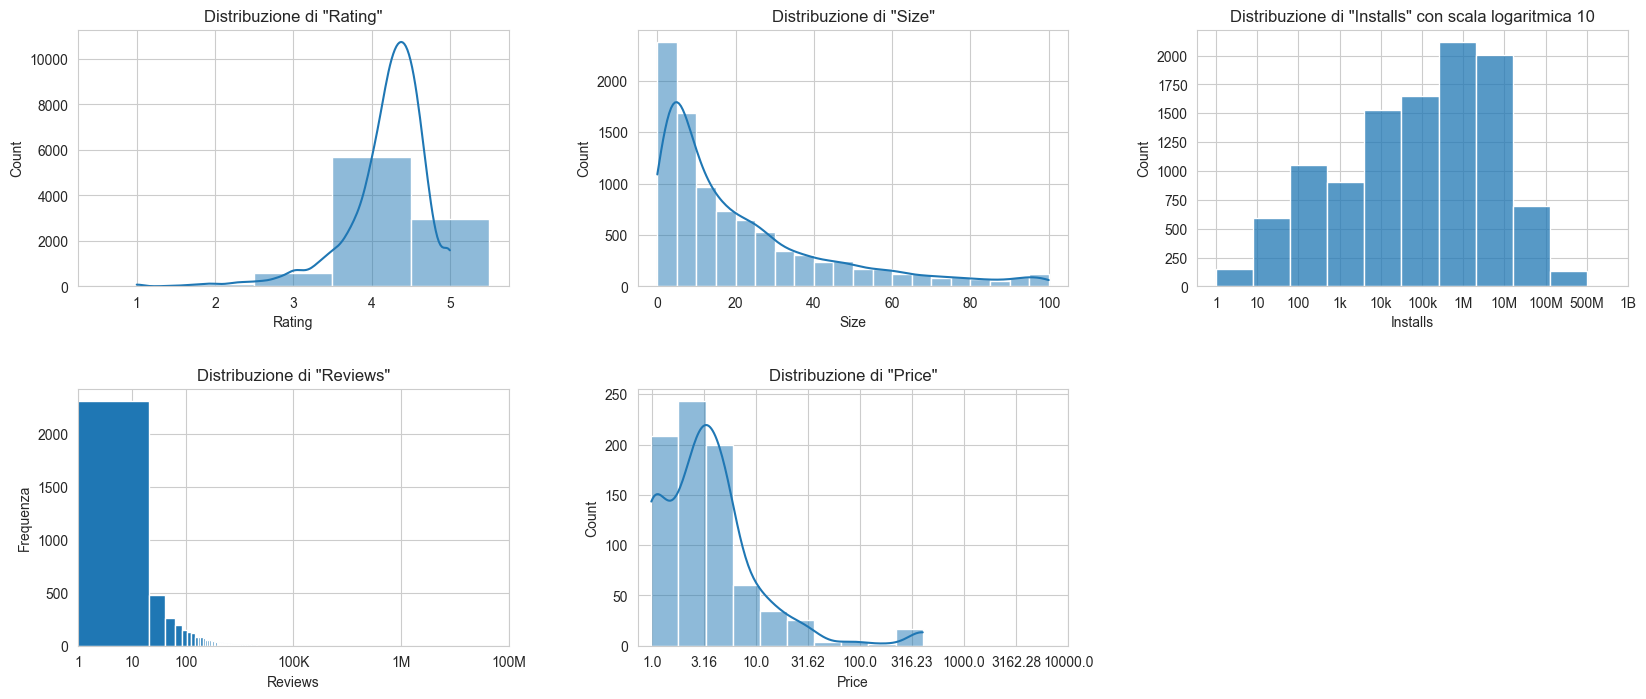

In [215]:
fig, axs = plt.subplots(2, 3, figsize=(20, 8))

# plot 1
sns.set_style("whitegrid")
sns.histplot(df["Rating"], bins=10, kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Distribuzione di "Rating"', fontsize=12)

# plot 2
sns.set_style("whitegrid")
sns.histplot(df["Size"], bins=20, kde=True, ax=axs[0, 1])
axs[0, 1].set_title('Distribuzione di "Size"', fontsize=12)

# plot 3
sns.set_style("whitegrid")
sns.histplot(np.log10(df["Installs"]), bins=10, ax=axs[0, 2])
axs[0, 2].set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
axs[0, 2].set_xticklabels(['1', '10', '100', '1k', '10k', '100k', '1M', '10M', '100M', '500M', '1B'])
axs[0, 2].set_xlabel('Installs')
axs[0, 2].set_title('Distribuzione di "Installs" con scala logaritmica 10', fontsize=12)

# plot 4
# imposto il range di visualizzazione solo sulla prima metà dell'istogramma
sns.set_style("whitegrid")
axs[1, 0].hist(df['Reviews'], bins=100, range=(0, df['Reviews'].quantile(0.5))) 
axs[1, 0].set_xscale('log')
axs[1, 0].set_title('Distribuzione di "Reviews"',fontsize=12)
xticks = [1, 10, 100, 10000, 1000000, 100000000]
xticklabels = ['1', '10', '100', '100K', '1M', '100M']
axs[1, 0].set_xticks(xticks)
axs[1, 0].set_xticklabels(xticklabels)
axs[1, 0].set_xlabel('Reviews')
axs[1, 0].set_ylabel('Frequenza')

# plot 5
sns.set_style("whitegrid")
sns.histplot(np.log10(df["Price"]), bins=10, kde=True, ax=axs[1, 1])
axs[1, 1].set_xticks(np.arange(0, 4.5, 0.5))
axs[1, 1].set_xticklabels([str(round(10**i, 2)) for i in np.arange(0, 4.5, 0.5)])
axs[1, 1].set_xlabel('Price')
axs[1, 1].set_title('Distribuzione di "Price"', fontsize=12)

axs[1, 2].axis('off')

plt.subplots_adjust(wspace=0.3, hspace=0.4)

plt.show

Vado subito a vedere la distribuzione del Rating che ritengo il parametro più importante per valutare un App, vedo che comunque la maggior parte delle App sono valutate positivamente, con un picco all'incirca sul 4.5.  
Faccio una premessa: le variabili 'Reviews', 'Price', 'Number of Installs' sono mostrate con logaritmo a base a 10 così da renderle più comprensibili avendo range molto ampi.  
Le variabili 'Size' e 'Price' mostrano una distribuzione Right-skewed, il che vuol dire che la maggior parte dei valori presenti del dataset sono bassi per entrambe le features, vanno diminuendo man mano che aumenta il prezzo o la dimensione dell'App.  
Il numero di installazioni presenta una distribuzione quasi normale, il picco si ha all'incirca sul milione di installazioni.  
Per quanto riguarda la variabile 'Reviews' concentro la visuale solo sulla prima metà del grafico perchè la maggior parte dei valori sono tutti lì. La maggior parte delle App hanno poche recensioni, sotto le 50 recensioni ad App.  
Queste info mi sono utili sia per una prima analisi sia per decidere come trattare i valori nulli e per capire come organizzare le fasi successive.

In [216]:
#riempio i NaN di "Rating" e "Size" col valore mediano
df['Rating'] = df['Rating'].fillna(df['Rating'].median()).astype(float)
df['Size'] = df['Size'].fillna(df['Size'].median())

In [217]:
#resetto per risistemare l'indice dopo le righe cancellate
df.reset_index(inplace=True)

In [218]:
#trasformo la colonna 'Last Updated' in tipo date
df['Last Updated'] = pd.to_datetime(df['Last Updated'])

#creo le colonne "month" e "year"
df['month'] = df['Last Updated'].dt.month
df['year'] = df['Last Updated'].dt.year

In [219]:
#controllo i valori unici della colonna "Category"
df['Category'].unique()

array(['ART_AND_DESIGN', 'AUTO_AND_VEHICLES', 'BEAUTY',
       'BOOKS_AND_REFERENCE', 'BUSINESS', 'COMICS', 'COMMUNICATION',
       'DATING', 'EDUCATION', 'ENTERTAINMENT', 'EVENTS', 'FINANCE',
       'FOOD_AND_DRINK', 'HEALTH_AND_FITNESS', 'HOUSE_AND_HOME',
       'LIBRARIES_AND_DEMO', 'LIFESTYLE', 'GAME', 'FAMILY', 'MEDICAL',
       'SOCIAL', 'SHOPPING', 'PHOTOGRAPHY', 'SPORTS', 'TRAVEL_AND_LOCAL',
       'TOOLS', 'PERSONALIZATION', 'PRODUCTIVITY', 'PARENTING', 'WEATHER',
       'VIDEO_PLAYERS', 'NEWS_AND_MAGAZINES', 'MAPS_AND_NAVIGATION'],
      dtype=object)

In [220]:
#guardo i valori unici della colonna "Genres"
df['Genres'].unique()

array(['Art & Design', 'Art & Design;Pretend Play',
       'Art & Design;Creativity', 'Art & Design;Action & Adventure',
       'Auto & Vehicles', 'Beauty', 'Books & Reference', 'Business',
       'Comics', 'Comics;Creativity', 'Communication', 'Dating',
       'Education;Education', 'Education', 'Education;Creativity',
       'Education;Music & Video', 'Education;Action & Adventure',
       'Education;Pretend Play', 'Education;Brain Games', 'Entertainment',
       'Entertainment;Music & Video', 'Entertainment;Brain Games',
       'Entertainment;Creativity', 'Events', 'Finance', 'Food & Drink',
       'Health & Fitness', 'House & Home', 'Libraries & Demo',
       'Lifestyle', 'Lifestyle;Pretend Play',
       'Adventure;Action & Adventure', 'Arcade', 'Casual', 'Card',
       'Casual;Pretend Play', 'Action', 'Strategy', 'Puzzle', 'Sports',
       'Music', 'Word', 'Racing', 'Casual;Creativity',
       'Casual;Action & Adventure', 'Simulation', 'Adventure', 'Board',
       'Trivia', 'Role 

In [221]:
size_counts = df['Size'].value_counts(dropna=False)
print(size_counts.head(25))

13.00    1885
11.00     198
12.00     196
14.00     194
15.00     184
17.00     160
19.00     154
16.00     149
26.00     149
10.00     146
25.00     143
20.00     139
21.00     138
24.00     136
18.00     133
23.00     117
22.00     114
29.00     103
27.00      97
28.00      95
30.00      84
33.00      79
3.30       77
37.00      76
35.00      72
Name: Size, dtype: int64


Dando un'occhiata ai valori unici della colonna 'Genres' mi accorgo che sono tantissimi i generi e nonostante sia interessante suddividerli così tanto, il tutto sarebbe più comprensibile riducendo i generi a "macrogeneri".

In [222]:
#creo un dizionario in cui ogni 'macrogenere' contiene i vari 'sottogeneri'
genres_dict = {
    'Art & Design': ['Art & Design', 'Art & Design;Pretend Play',
       'Art & Design;Creativity','Art & Design;Action & Adventure'],
    'Auto & Vehicles': ['Auto & Vehicles'],
    'Beauty': ['Beauty'],
    'Business': ['Business'],
    'Comics': ['Comics','Comics; Creativity'],
    'Communication': ['Communication'],
    'Dating': ['Dating'],
    'Education': ['Education','Education;Creativity',
    'Education;Education',
    'Educational;Creativity'
    'Educational;Education','Educational;Creativity','Educational;Education','Educational','Education;Music & Video'],
    'Educational Games; Brain Games': ['Educational;Brain Games','Educational;Pretend Play','Education;Action & Adventure',
    'Education;Pretend Play',
    'Education;Brain Games','Educational;Action & Adventure','Trivia','Entertainment;Brain Games','Trivia;Education'],
    'Entertainment;Music & Video': ['Entertainment','Entertainment;Music & Video','Entertainment; Music & Video',
                                    'Entertainment;Education',
                                    'Entertainment;Creativity'],
    'Events': ['Events'],
    'Finance': ['Finance'],
    'Food & Drink': ['Food & Drink'],
    'Health & Fitness': ['Health & Fitness','Health & Fitness;Education',
    'Health & Fitness;Action & Adventure'],
    'House & Home': ['House & Homes'],
    'Libraries & Demo': ['Libraries & Demo'],
    'Lifestyle': ['Lifestyle'],
    'Action & Adventure': ['Adventure','Action;Action & Adventure','Adventure;Action & Adventure',
    'Action','Adventure;Brain Games','Entertainment;Action & Adventure','Adventure;Education'],
    'Arcade; Casual; Creativity; Puzzle': ['Casual;Pretend Play',
    'Casual;Brain Games',
    'Casual;Action & Adventure',
    'Casual;Music & Video',
    'Casual;Education','Casual;Action & Adventure','Puzzle;Action & Adventure',
    'Arcade;Action & Adventure','Arcade',
    'Casual',
    'Casual;Pretend Play',
    'Arcade;Pretend Play','Puzzle',
    'Puzzle;Brain Games',
    'Puzzle;Creativity',
    'Puzzle;Education','Casual;Creativity'],
    'Card': ['Card',
    'Card;Brain Games',
    'Card;Action & Adventure'],
    'Strategy': ['Strategy',
    'Strategy;Action & Adventure',
    'Strategy;Education',
    'Strategy;Creativity'],
    'Sports': ['Sports;Action & Adventure','Sports'],
    'Word': ['Word'],
    'Racing': ['Racing','Racing;Action & Adventure','Racing;Pretend Play'],
    'Simulation': ['Simulation;Action & Adventure','Simulation',
'Simulation;Pretend Play',
'Simulation;Education'],
    'Role Playing;Pretend Play': ['Entertainment;Pretend Play','Role Playing',
'Role Playing;Pretend Play',
'Role Playing;Brain Games','Lifestyle;Pretend Play','Role Playing;Action & Adventure','Role Playing;Education'],
    'Medical': ['Medical'],
    'Social': ['Social'],
    'Shopping': ['Shopping'],
    'Photography': ['Photography'],
    'Travel & Local': ['Travel & Local',
'Travel & Local;Action & Adventure'],
    'Tools': ['Tools','Tools;Education'],
    'Personalization': ['Personalization'],
    'Productivity': ['Productivity'],
    'Parenting': ['Parenting','Parenting;Brain Games',
'Parenting;Education',
'Parenting;Music & Video'],
    'Weather': ['Weather'],
    'Video Players & Editors': ['Video Players & Editors',
'Video Players & Editors;Creativity',
'Video Players & Editors;Music & Video'],
    'News & Magazines': ['News & Magazines'],
    'Maps & Navigation': ['Maps & Navigation'],
    'Casino': ['Casino'],
    'Comics': ['Comics','Comics;Creativity'],
    'Books & Reference': ['Books & Reference;Education','Books & Reference;Creativity'],
    'Board' :['Board;Brain Games','Board','Board;Action & Adventure','Board;Pretend Play'],
    'Music': ['Music;Music & Video','Music & Audio;Music & Video']
    
}

In [223]:
#creo una funzione che riduce i generi
def map_genres(genre, genres_dict):
    for category, values in genres_dict.items():
        if genre in values:
            return category
    return genre

In [224]:
#applico la funzione alla colonna 'Genres' e creo la nuova colonna con i generi aggiornati
df['new_genres'] = df['Genres'].apply(lambda x: map_genres(x, genres_dict))

print(f"Gli elementi unici della colonna 'Genres' erano: {len(df.Genres.unique())}")
print(f"Gli elementi unici della nuova colonna 'new_genres' sono: {len(df.new_genres.unique())}")

Gli elementi unici della colonna 'Genres' erano: 119
Gli elementi unici della nuova colonna 'new_genres' sono: 45


In [225]:
df['new_genres'].unique()

array(['Art & Design', 'Auto & Vehicles', 'Beauty', 'Books & Reference',
       'Business', 'Comics', 'Communication', 'Dating', 'Education',
       'Educational Games; Brain Games', 'Entertainment;Music & Video',
       'Events', 'Finance', 'Food & Drink', 'Health & Fitness',
       'House & Home', 'Libraries & Demo', 'Lifestyle',
       'Role Playing;Pretend Play', 'Action & Adventure',
       'Arcade; Casual; Creativity; Puzzle', 'Card', 'Strategy', 'Sports',
       'Music', 'Word', 'Racing', 'Simulation', 'Board',
       'Video Players & Editors', 'Medical', 'Social', 'Shopping',
       'Photography', 'Travel & Local', 'Tools', 'Personalization',
       'Productivity', 'Parenting', 'Weather', 'News & Magazines',
       'Maps & Navigation', 'Casino', 'Lifestyle;Education',
       'Communication;Creativity'], dtype=object)

In [226]:
#mostro com'è composta la colonna 'Current Ver'
android_counts = df['Android Ver'].value_counts(dropna=False)
print(android_counts.head(25))

4.1 and up            2451
4.0.3 and up          1501
4.0 and up            1376
Varies with device    1361
4.4 and up             980
2.3 and up             652
5.0 and up             601
4.2 and up             394
2.3.3 and up           281
2.2 and up             244
4.3 and up             243
3.0 and up             241
2.1 and up             134
1.6 and up             116
6.0 and up              60
7.0 and up              42
3.2 and up              36
2.0 and up              32
5.1 and up              24
1.5 and up              20
4.4W and up             12
3.1 and up              10
2.0.1 and up             7
8.0 and up               6
7.1 and up               3
Name: Android Ver, dtype: int64


I valori della colonna "Android Ver" sono particolari perchè sono concettualmente numerici ma in realtà delle vere e proprie stringhe avendo vere e proprie scritte accanto ai numeri, oltre al solito "Varies with device". Decido di prendere il primo numero di ogni riga e di riempire i "NaN" o i "Varies with device" con il valore più frequente, ossia la moda.

In [227]:
#prendo il primo carattere di ogni valore
df['Android Ver'] = df['Android Ver'].str[0]
#calcolo la moda
mode_value = df['Android Ver'].mode()[0]
#riempio i valori nan o 'V' con la moda
for i, val in enumerate(df['Android Ver']):
    if val == 'V' or pd.isna(val) :
        df['Android Ver'][i] = mode_value

In [228]:
current_ver_counts = df['Current Ver'].value_counts(dropna=False)
print(current_ver_counts.head(25))

Varies with device    1458
1.0                    809
1.1                    264
1.2                    178
2.0                    151
1.3                    145
1.0.0                  136
1.0.1                  119
1.4                     88
1.5                     81
1.0.2                   80
1.6                     65
1.0.3                   62
2.1                     61
3.0                     59
1.0.4                   58
1.7                     53
2.0.0                   51
1.0.5                   50
1.1.0                   49
1.1.1                   48
1.0.6                   47
1.2.1                   46
1.2.0                   43
1.8                     42
Name: Current Ver, dtype: int64


Non credo che questa colonna possa aggiungere qualcosa di interessante, decido quindi di eliminare le colonne 'Current Ver', 'Last Updated' e 'Genres'. La prima perchè non la ritengo utile per l'analisi, le ultime due perchè ho scelto di analizzarle sotto altra forma generando altre colonne.

In [229]:
df.drop(['Current Ver', 'Last Updated', 'Genres','index'],axis=1,inplace=True)

In [230]:
#Rinomino la colonna perchè lo spazio tra i due nomi può dare problemi in alcuni passaggi
df = df.rename(columns={'Content Rating': 'Content_Rating','Android Ver':'Android_Ver'})

In [231]:
#controllo presenza di valori duplicati
df.duplicated().sum()

484

In [232]:
df.drop_duplicates(inplace=True)
print("Le righe rimanenti sono:",df.shape[0])

Le righe rimanenti sono: 10356


In [233]:
pd.options.display.float_format = '{:.2f}'.format
df.describe(exclude=["int64",'object']).T

,count,mean,std,min,25%,50%,75%,max
Rating,10356.00,4.20,0.49,1.00,4.10,4.30,4.50,5.00
Reviews,10356.00,405930.85,2696906.73,0.00,32.00,1678.50,46380.75,78158306.00
Size,10356.00,20.07,21.02,0.01,5.70,13.00,26.00,100.00
Installs,10356.00,14158161.02,80243417.79,0.00,1000.00,100000.00,1000000.00,1000000000.00
Price,10356.00,1.03,16.28,0.00,0.00,0.00,0.00,400.00


Dando un'occhiata al riassunto statistico della colonna 'Rating' vediamo che come visto precedentemente nel grafico, la sua distribuzione è principalmente attorno al 4.5, c'è un minimo di 1 ma comunque pochi dati. "Reviews" e "Installs" hanno range molto ampi, in particolare il secondo. "Price" come abbiamo visto prima ha valori molto bassi, nonostante un massimo di 400 quasi tutti i numeri sono tra 0 e 1.

Arrivati a questo punto decido di creare un'altro dataframe partendo da quello iniziale in cui vado a selezionare solo le App migliori considerando Recensioni, Installazioni e Rating, svolgerò quindi un'analisi parallela per valutare sia la composizione del Dataset in generale sia il dataframe ristretto sulle App che possiamo considerare "migliori".

In [234]:
dfM = df[(df['Reviews']>=1000) & (df['Installs']>=100000) & (df['Rating']>=4.3)]

In [235]:
dfM.shape

(3135, 13)

## 3. Exploratory Data Analysis (EDA) <a class="anchor" id="third-bullet"></a>

In [236]:
cat_count = df['Category'].value_counts().sort_values()
category_order = cat_count.index.tolist()

In [237]:
fig = px.histogram(df, y="Category", color="new_genres", barmode="stack", 
                   color_discrete_sequence=px.colors.qualitative.Alphabet,
                   title="Numero di App per categoria e genere",
                   labels={"Category": "Category", "count()": "Numero di App"})
fig.update_layout(width=980, height=900)
fig.update_yaxes(categoryorder="array", categoryarray=category_order)
fig.update_layout(xaxis_title="Numero di App", yaxis_title="")
fig.show()

La categoria più rappresentata è chiaramente 'Family', con all'interno vari sottogeneri, tra i più rappresentati troviamo 'Education' (istruzione), e giochi simil Arcade, Puzzle, ecc. Al secondo posto la categoria 'Game' con quasi la metà delle App presenti, maggior parte di giochi riguardano Azione e Avventura, e anche qui i giochi Arcade, Puzzle, ecc. Al terzo posto i Tools e a seguire tutte le altre categorie. Quelle meno presenti sono 'Parenting', 'Beauty' e 'Events'.

In [238]:
cat_count_r = dfM['Category'].value_counts().sort_values()
category_order_r = cat_count_r.index.tolist()

fig = px.histogram(dfM, y="Category", color="new_genres", barmode="stack", 
                   color_discrete_sequence=px.colors.qualitative.Light24,
                   title="Numero di App per categoria e genere (App migliori)",
                   labels={"Category": "Category", "count()": "Numero di App"})
fig.update_layout(width=980, height=900)
fig.update_yaxes(categoryorder="array", categoryarray=category_order_r)
fig.update_layout(xaxis_title="Numero di App", yaxis_title="")
fig.show()

Prendendo in considerazione solo le applicazioni che hanno almeno 100000 installazioni, almeno 1000 recensioni e rating >=4.3, questo è il risultato. La categoria "Game" passa avanti a "Family", il che vuol dire che la maggior parte delle App con tante installazioni e recensioni e un alto Rating sono giochi, comunque anche prodotti "Family" sono ben piazzati, vedendo queste prime due posizioni comunque i giochi stile Arcande, Puzzle ecc. hanno il sopravvento, oltre che i giochi 'Action & Adventure'. In gran parte la classifica rimane simile, troviamo comunque in posizioni migliori "Photography" e "Health and Fitness".

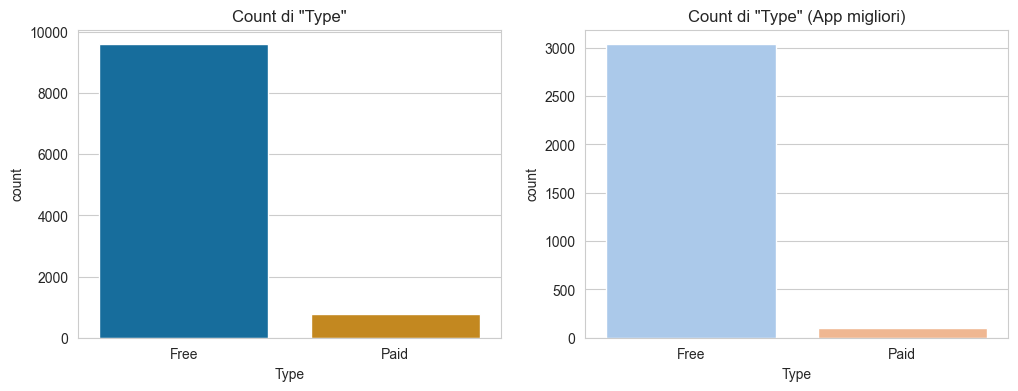

In [239]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.set_style("whitegrid")
sns.countplot(x="Type", data=df, ax=ax1,palette='colorblind')
ax1.set_title('Count di "Type"')

sns.set_style("whitegrid")
sns.countplot(x="Type", data=dfM, ax=ax2,palette='pastel')
ax2.set_title('Count di "Type" (App migliori)')

plt.show()

La maggior parte delle App presenti nello store sono chiaramente gratuite (e per fortuna!). Inoltre anche nella selezione delle App migliori, anche lì la maggioranza è nettamente gratuita.

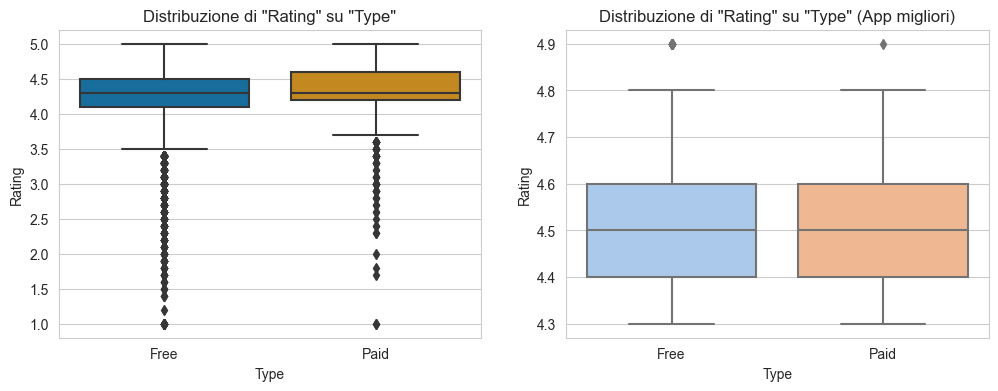

In [240]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.set_style("whitegrid")
sns.boxplot(x='Type', y='Rating', data=df,ax=ax1,palette='colorblind')
ax1.set_title('Distribuzione di "Rating" su "Type"')

sns.set_style("whitegrid")
sns.boxplot(x='Type', y='Rating', data=dfM,ax=ax2,palette='pastel')
ax2.set_title('Distribuzione di "Rating" su "Type" (App migliori)')

plt.show()

Da questi boxplot notiamo che un App a pagamento ha più probabilità di essere ben recensita, anche se di poco, infatti prendendo in considerazione solo le App migliori non cambia praticamente nulla.

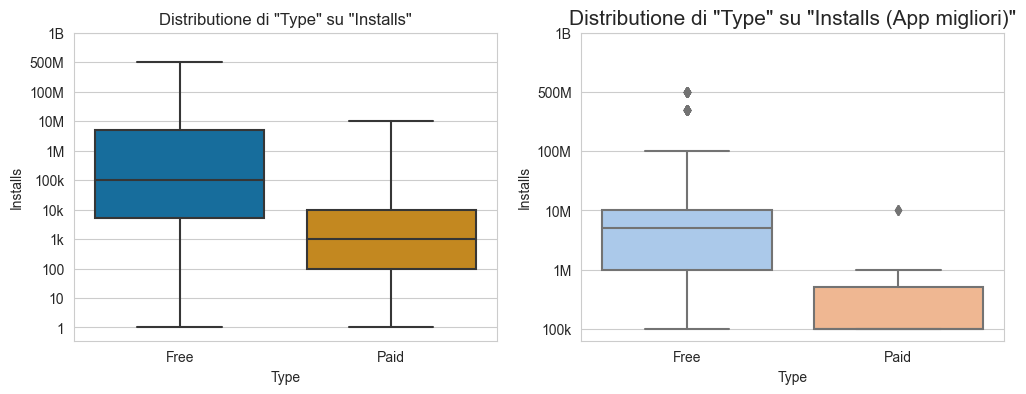

In [241]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

sns.set_style("whitegrid")
sns.boxplot(x='Type', y=np.log10(df['Installs']), data=df,ax=ax1,palette='colorblind')
ax1.set_title('Distributione di "Type" su "Installs"')
ax1.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
ax1.set_yticklabels(['1', '10', '100', '1k', '10k', '100k', '1M', '10M', '100M', '500M', '1B'])


sns.set_style("whitegrid")
sns.boxplot(x='Type', y=np.log10(df['Installs']), data=dfM,ax=ax2,palette='pastel')
ax2.set_title('Distributione di "Type" su "Installs (App migliori)"', size=15)
ax2.set_yticks([5, 6, 7, 8, 9, 10])
ax2.set_yticklabels(['100k', '1M', '10M', '100M', '500M', '1B'])


plt.show()

Il numero di installazioni è più alto (di molto, considerando il range dei valori) per le applicazioni gratis in tutti i casi e diciamo che il motivo è abbastanza logico.

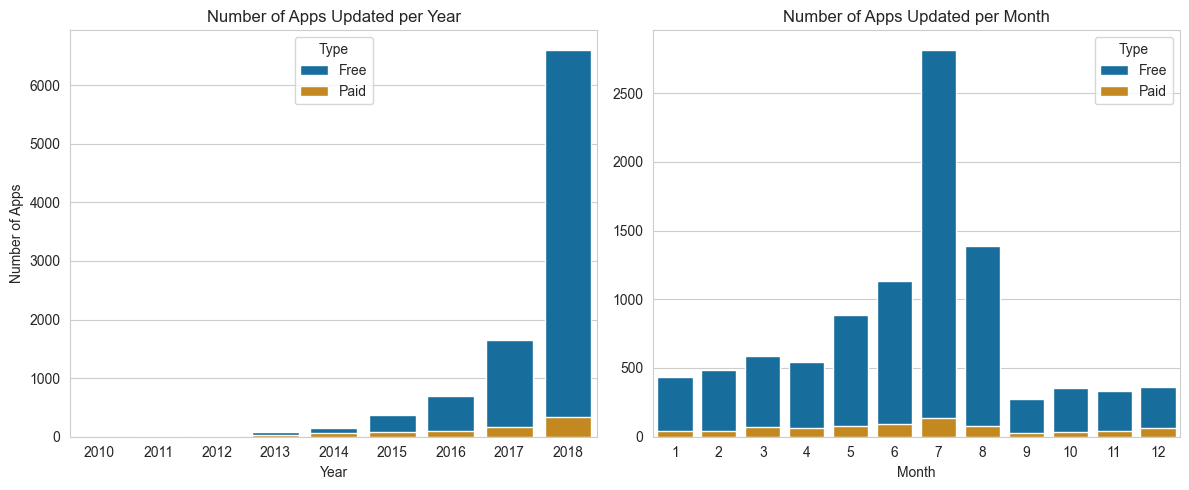

In [242]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

year_counts = df.groupby(['year', 'Type'])['App'].count().reset_index()
sns.barplot(x='year', y='App', hue='Type', data=year_counts, ax=ax1,dodge=False,palette='colorblind')

ax1.set_xlabel('Year')
ax1.set_ylabel('Number of Apps')
ax1.set_title('Number of Apps Updated per Year')

month_counts = df.groupby(['month', 'Type'])['App'].count().reset_index()
sns.barplot(x='month', y='App', hue='Type', data=month_counts, ax=ax2,dodge=False,palette='colorblind')

ax2.set_xlabel('Month')
ax2.set_ylabel('')
ax2.set_title('Number of Apps Updated per Month')

plt.tight_layout()
plt.show()

La maggior parte delle App presenti sono aggiornate nel 2018 (ultimo anno disponibile). Per qualche motivo che attualmente non conosco la maggior parte delle App sono aggiornate o inserite nel mese di Luglio, mentre Settembre è il periodo "peggiore". Si potrebbe ipotizzare che a Luglio ci sia una sorta di "fretta" di finire le app da sviluppare prima delle ferie di Agosto, il che spiegherebbe anche le poche App aggiornate/inserite a Settembre.

In [243]:
#dò un'occhiata al value_counts di "year"
df.year.value_counts()

2018    6933
2017    1826
2016     789
2015     454
2014     204
2013     108
2012      26
2011      15
2010       1
Name: year, dtype: int64

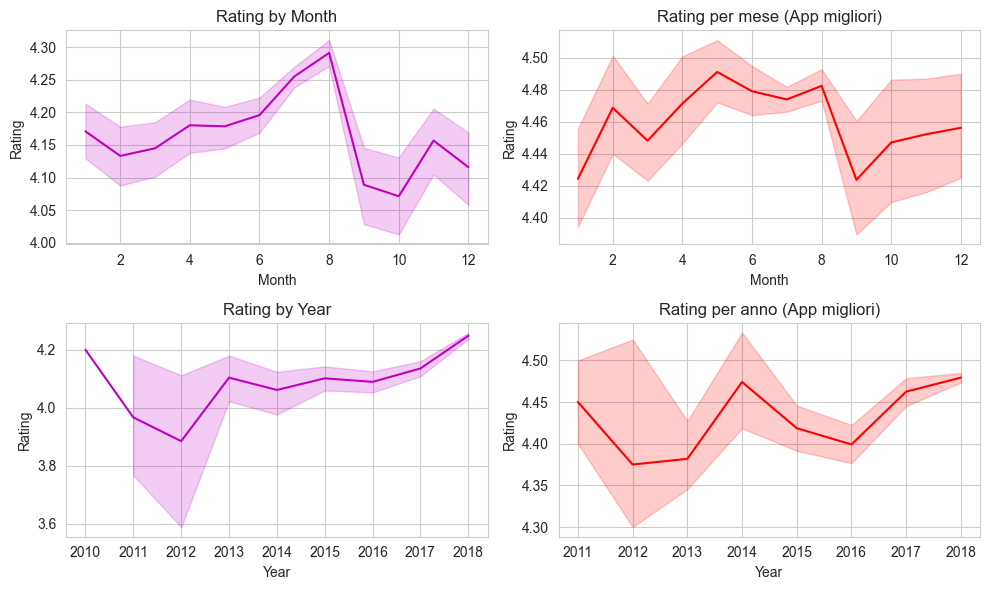

In [244]:
fig, ax = plt.subplots(ncols=2,nrows=2, figsize=(10, 6))

sns.lineplot(x="month", y="Rating", data=df, ax=ax[0][0],color='m')
ax[0][0].set_xlabel('Month')
ax[0][0].set_ylabel('Rating')
ax[0][0].set_title('Rating by Month')

sns.lineplot(x="month", y="Rating", data=dfM, ax=ax[0][1],color='r')
ax[0][1].set_xlabel('Month')
ax[0][1].set_ylabel('Rating')
ax[0][1].set_title('Rating per mese (App migliori)')

sns.lineplot(x="year", y="Rating", data=df, ax=ax[1][0],color='m')
ax[1][0].set_xlabel('Year')
ax[1][0].set_ylabel('Rating')
ax[1][0].set_title('Rating by Year')

sns.lineplot(x="year", y="Rating", data=dfM, ax=ax[1][1],color='r')
ax[1][1].set_xlabel('Year')
ax[1][1].set_ylabel('Rating')
ax[1][1].set_title('Rating per anno (App migliori)')

plt.tight_layout()

plt.show()

A livello di Rating le App inserite a Luglio e Agosto sembrano essere quelle recensite meglio, col calo grande a settembre e ottobre. Nella selezione delle App migliori vediamo comunque Maggio "a sorpresa" apparire come mese con Rating migliore. Per quanto riguarda l'anno non considerando il 2010 che è presente in un solo elemento del dataset, per il resto il Rating aumenta sempre e nell'anno più recente si hanno app recensite meglio. Diciamo che in generale i grafici sugli anni comunicano poco, da ora in poi infatti non li considererò più di tanto, dando semplicemente per scontato che un'app più recente è sicuramente meglio.

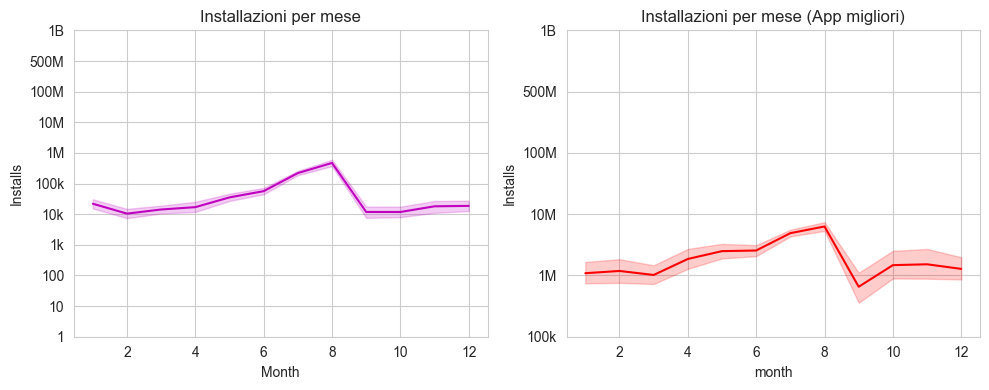

In [245]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))

sns.lineplot(x="month", y=np.log10(df['Installs']), data=df, ax=ax[0],color='m')
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Installs')
ax[0].set_title('Installazioni per mese')
ax[0].set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
ax[0].set_yticklabels(['1', '10', '100', '1k', '10k', '100k', '1M', '10M', '100M', '500M', '1B'])

sns.set_style("whitegrid")
sns.lineplot(x='month', y=np.log10(df['Installs']), data=dfM,ax=ax[1],color='r')
ax[1].set_title('Installazioni per mese (App migliori)')
ax[1].set_yticks([5, 6, 7, 8, 9, 10])
ax[1].set_yticklabels(['100k', '1M', '10M', '100M', '500M', '1B'])

plt.tight_layout()

plt.show()

Dò un'occhiata anche al numero di installazioni in baso a quando l'app è stata inserita o aggiornata. Anche qui i mesi più interessanti sembrano quelli estivi sia sul dataset generale che nel focus sulle App migliori. Su entrambi i grafici si verifica una crescita da marzo in poi, per poi scendere a settembre e ricominciare allo stesso livello da ottobre fino a febbraio.

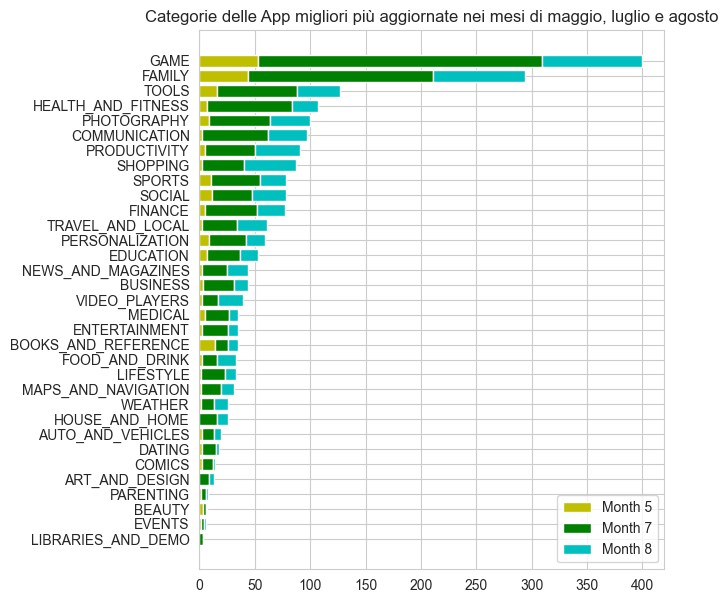

In [246]:
selected_months = [5, 7, 8]
df_selected = dfM[dfM['month'].isin(selected_months)].groupby('Category')['month'].count()
df_selected = df_selected.sort_values(ascending=True)

data = {}
for month in selected_months:
    month_data = dfM[dfM['month'] == month].groupby('Category')['month'].count()
    data[month] = month_data.reindex(df_selected.index).fillna(0).tolist()

fig, ax = plt.subplots(figsize=(6, 7))
ax.barh(df_selected.index, data[5], label='Month 5',color='y')
ax.barh(df_selected.index, data[7], left=data[5], label='Month 7',color='g')
ax.barh(df_selected.index, data[8], left=[data[5][i] + data[7][i] for i in range(len(data[5]))], label='Month 8',color='c')
ax.legend()
ax.set_title('Categorie delle App migliori più aggiornate nei mesi di maggio, luglio e agosto')
plt.show()

Tra le App aggiornate a Maggio, Luglio e Agosto ai primi posti troviamo sempre le stesse 3, cambia un po' dopo visto che troviamo Health and Fitness salire, comunque in linea di massima non c'è troppa differenza. Vediamo meglio con le successive analisi.

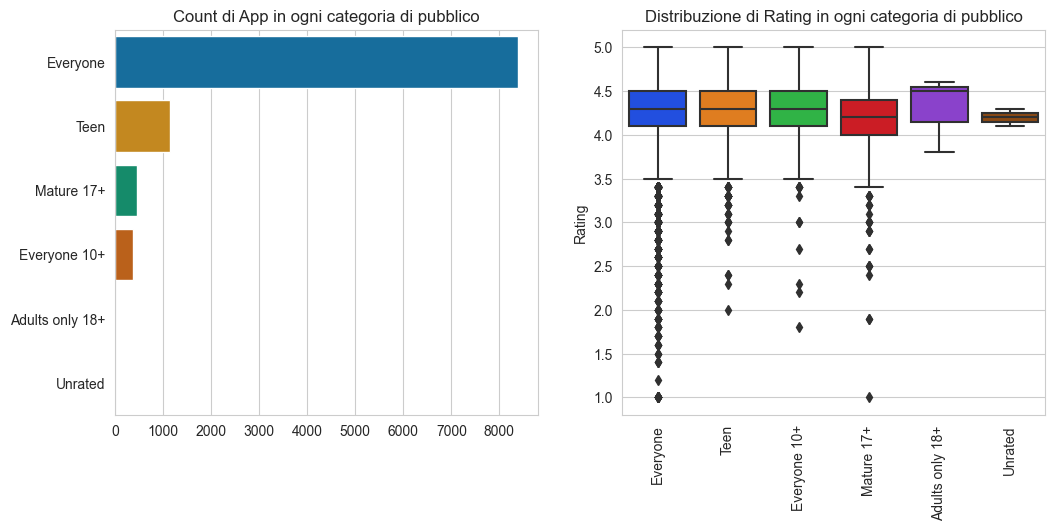

In [247]:
content_counts = df['Content_Rating'].value_counts()

content_order = content_counts.index.tolist()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x=content_counts.values, y=content_order, palette="colorblind", ax=ax1)
ax1.set_title('Count di App in ogni categoria di pubblico', size=12)

sns.boxplot(x='Content_Rating', y='Rating', data=df, ax=ax2,palette='bright')
ax2.set_title('Distribuzione di Rating in ogni categoria di pubblico', size=12)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_xlabel("")

plt.show()

La maggior parte delle App sono destinate a un pubblico senza restrizioni. Al secondo posto ma molto lontano un pubblico 'Teen'. Non c'è molta differenza per quanto riguarda il 'Rating', non considerando le ultime due categorie che hanno un numero di valori troppo basso, le categorie più o meno si attestano sullo stesso livello di Rating. E' vero che Everyone presenta più outliers ma ha un numero di presenze troppo più alto degli altri e quindi considerabile "migliore".

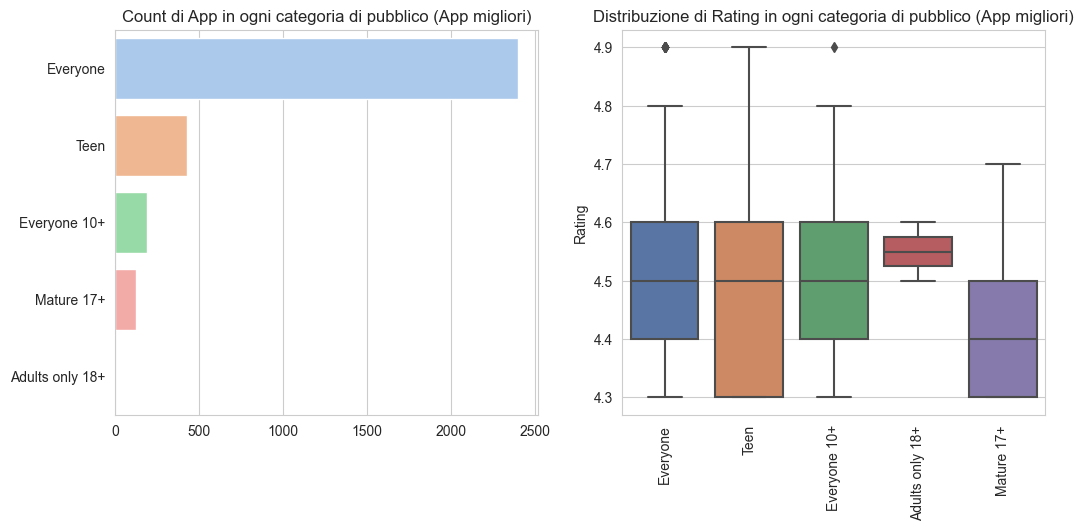

In [248]:
content_counts_r = dfM['Content_Rating'].value_counts()

content_order_r = content_counts_r.index.tolist()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))


sns.barplot(x=content_counts_r.values, y=content_order_r, palette="pastel", ax=ax1)
ax1.set_title('Count di App in ogni categoria di pubblico (App migliori)', size=12)

sns.boxplot(x='Content_Rating', y='Rating', data=dfM, ax=ax2,palette="deep")
ax2.set_title('Distribuzione di Rating in ogni categoria di pubblico (App migliori)', size=12)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_xlabel("")

plt.show()

Per quanto riguarda solo le App migliori anche qui la situazione è simile, analogamente al discorso precedente la categoria "Everyone" è considerabile quella più "solida",essendo sia la più presente sia quella col range di Rating più alto.

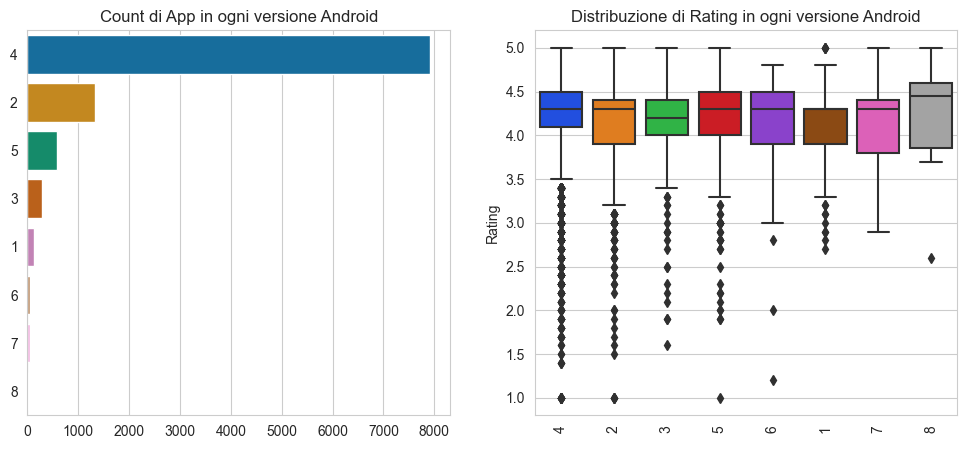

In [249]:
android_counts_r = df['Android_Ver'].value_counts()

android_order_r = android_counts_r.index.tolist()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x=android_counts_r.values, y=android_order_r, palette="colorblind", ax=ax1)
ax1.set_title('Count di App in ogni versione Android', size=12)

sns.boxplot(x='Android_Ver', y='Rating', data=df, ax=ax2,palette='bright')
ax2.set_title('Distribuzione di Rating in ogni versione Android', size=12)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_xlabel("")

plt.show()

Dai questi due grafici possiamo notare che la versione di Android in cui sono disponibili più App è la 4. Come distribuzione si può dire che nonostante siano più o meno tutte sullo stesso livello, considerando sempre che la 4 ha un Count molto più elevato è sempre considerabile migliore.

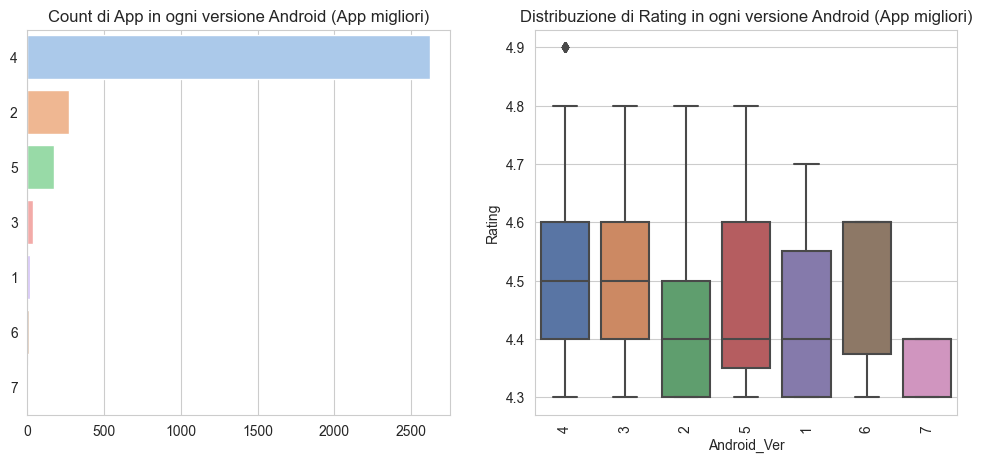

In [250]:
android_counts_r = dfM['Android_Ver'].value_counts()

android_order_r = android_counts_r.index.tolist()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.barplot(x=android_counts_r.values, y=android_order_r, palette="pastel", ax=ax1)
ax1.set_title('Count di App in ogni versione Android (App migliori)', size=12)

sns.boxplot(x='Android_Ver', y='Rating', data=dfM, ax=ax2,palette="deep")
ax2.set_title('Distribuzione di Rating in ogni versione Android (App migliori)', size=12)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)

plt.show()

Discorso praticamente uguale al precedente anche sulle App migliori, la versione migliore su cui sviluppare un App è la 4 (devi avere almeno Android 4 insomma).

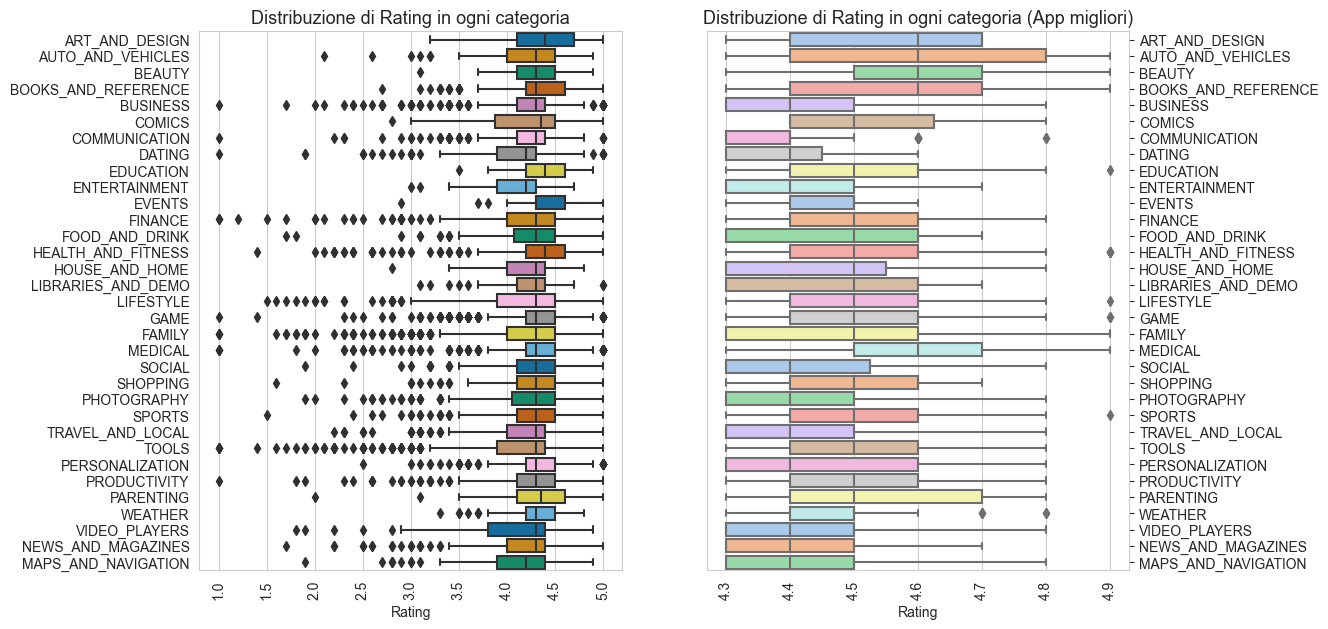

In [251]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))

sns.boxplot(x='Rating', y='Category', data=df, ax=ax1,palette="colorblind")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_ylabel(None)
ax1.set_title('Distribuzione di Rating in ogni categoria', size=13)


sns.boxplot(x='Rating', y='Category', data=dfM, ax=ax2,palette="pastel")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.yaxis.tick_right()
ax2.set_ylabel(None)
ax2.set_title('Distribuzione di Rating in ogni categoria (App migliori)', size=13)

plt.show()

Dando un'occhiata al grafico precedente possiamo vedere le categorie che hanno più probabilità di avere un rating più alto, quella più virtuosa sembra essere 'Events' anche se c'è da considerare che era tra le ultime come presenze nel dataset. "Art and Design", "Books and Reference", "Education", "Parenting", "Health and Fitness" sono altre categorie con alta probabilità di avere un alto Rating. Anche "Game" e "Shopping" sembrano garantire "certezze" di rating alto.  
Selezionando invece solo le App migliori, quella che raggiunge livelli più alti è "Auto and Vehicles", buoni risultati anche per "Medical", "Parenting","Beauty", "Books and Reference", "Art and Design" tutte tra le ultime come "presenze" però quelle che ci sono sembrano garantire un buon Rating. Sicuramente da evitare per un'eventuale App la categoria "Entertainment".

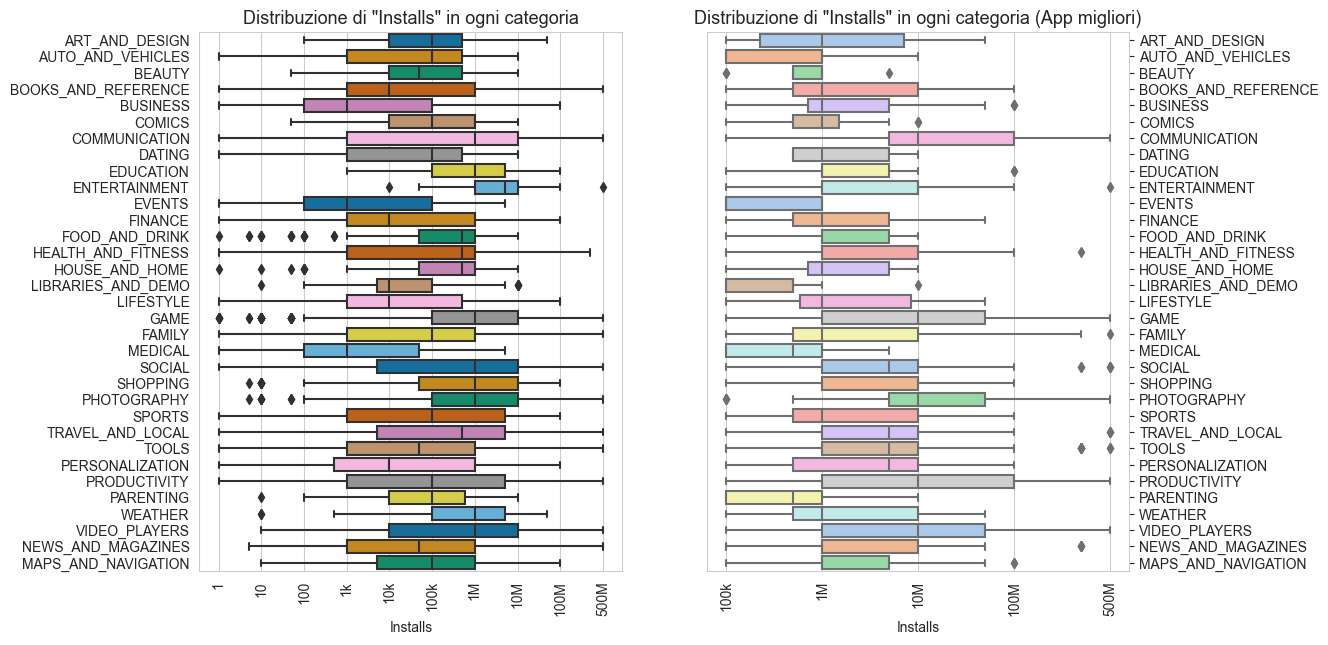

In [252]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))

sns.boxplot(x=np.log10(df['Installs']), y='Category', data=df, ax=ax1,palette="colorblind")
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
ax1.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
ax1.set_xticklabels(['1', '10', '100', '1k', '10k', '100k', '1M', '10M', '100M', '500M'])
ax1.set_ylabel(None)
ax1.set_title('Distribuzione di "Installs" in ogni categoria', size=13)

sns.boxplot(x=np.log10(df['Installs']), y='Category', data=dfM, ax=ax2,palette="pastel")
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=90)
ax2.set_xticks([5, 6, 7, 8, 9])
ax2.set_xticklabels(['100k', '1M', '10M', '100M', '500M'])
ax2.yaxis.tick_right()
ax2.set_ylabel(None)
ax2.set_title('Distribuzione di "Installs" in ogni categoria (App migliori)', size=13)

plt.show()

Diamo un'occhiata anche al numero di installazioni rapportato alle categorie, qui 'Entertainment' che nel grafico di prima aveva la posizione peggiore ha invece la posizione migliore. Tante persone scaricano applicazioni di intrattenimento ma c'è evidentemente un alto rischio di produrre app non gradite. 'Game', 'Shopping', 'Photography','Weather', categorie ben messe a livello di installazioni.  
Per quando riguarda le App migliori risultano come più installate quelle di "Communication","Productivity","Photography","Game","Video_Players".  
Rispetto al boxplot riguardante il Rating qui "Art and Design","Auto and Vehicles, "Beauty", "Medical", "Parenting" ne escono male, tra le peggiori. "Events" che aveva un buon Rating come installazioni è invece pessima.

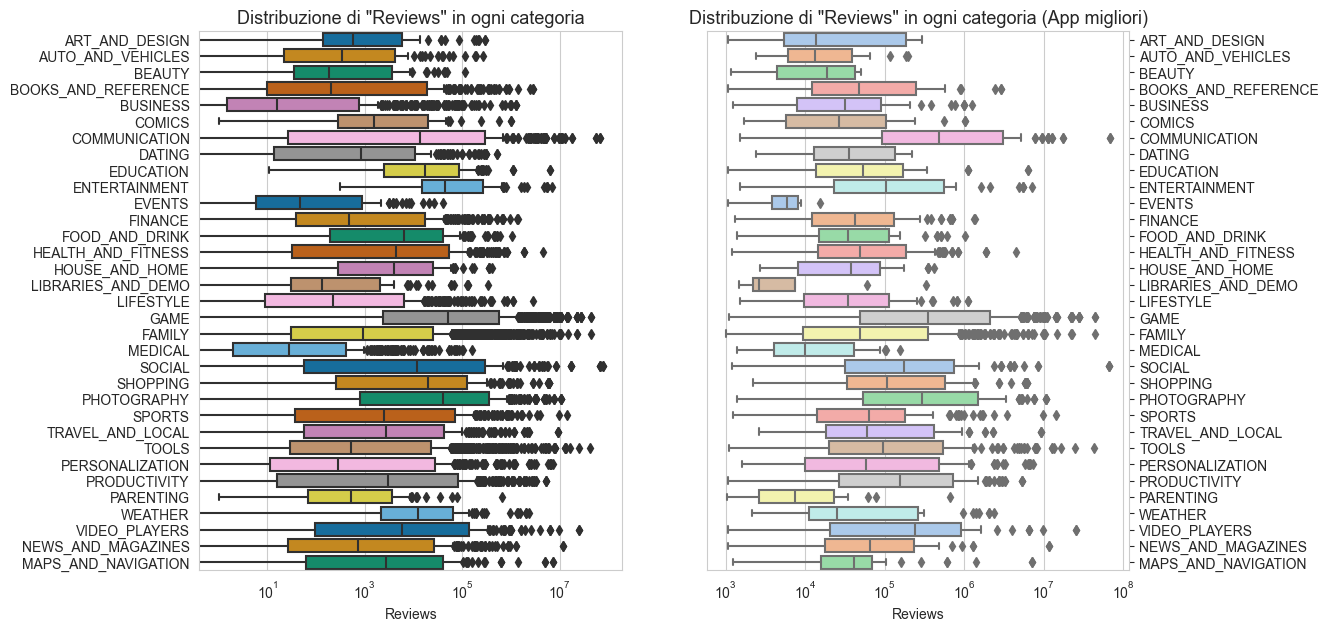

In [253]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 7))
sns.boxplot(x=df['Reviews'], y='Category', data=df, ax=ax1,palette="colorblind")
ax1.set_ylabel(None)
ax1.set_xscale('log')
ax1.set_title('Distribuzione di "Reviews" in ogni categoria', size=13)

sns.boxplot(x='Reviews', y='Category', data=dfM, ax=ax2,palette="pastel")
ax2.set_xscale('log')
ax2.yaxis.tick_right()
ax2.set_ylabel(None)
ax2.set_title('Distribuzione di "Reviews" in ogni categoria (App migliori)', size=13)

plt.show()

Per quanto riguarda il numero di recensioni anche qui "Game" è molto ben messa. Anche 'Photography','Social', "Entertainment" (che però avevamo visto il Rating era basso), "Shopping" e "Video Players" presentano un buon numero di recensioni. La categoria "Events" che aveva un Rating alto ha un numero basso di recensioni per app oltre che di installazioni.  
Guardando alle App migliori spicca "Communication", ancora "Game", "Photography", ben messe anche "Entertainment e "Video Players". Anche qui da evitare "Events", oltre che "Parenting", "Medical", "Libraries and Demo".

In [254]:
#trasformo 'month' e 'Android_Ver' in stringhe per non renderli analizzabili dalle correlazioni, essendo non numerici
df['month'] = df['month'].astype("string")
df['Android_Ver'] = df['Android_Ver'].astype("string")

#elimino la colonna 'year' perchè i suoi risultati li ritingo poco utili
df.drop('year',axis=1,inplace=True)

<AxesSubplot: >

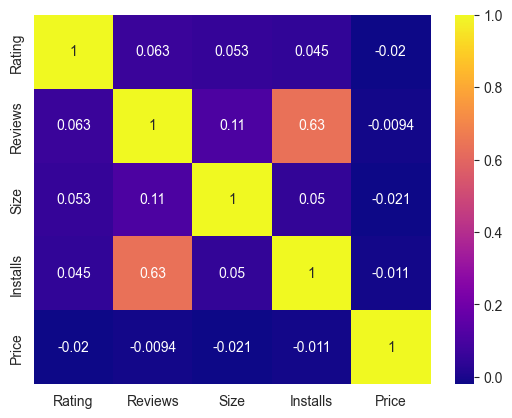

In [255]:
#mostro la correlation matrix
sns.heatmap(df.corr(),annot=True,cmap='plasma')

Vedendo la Correlation Matrix, a parte una buona correlazione tra "Installs" e "Reviews" gli altri valori non comunicano nessuna relazione tra variabili.

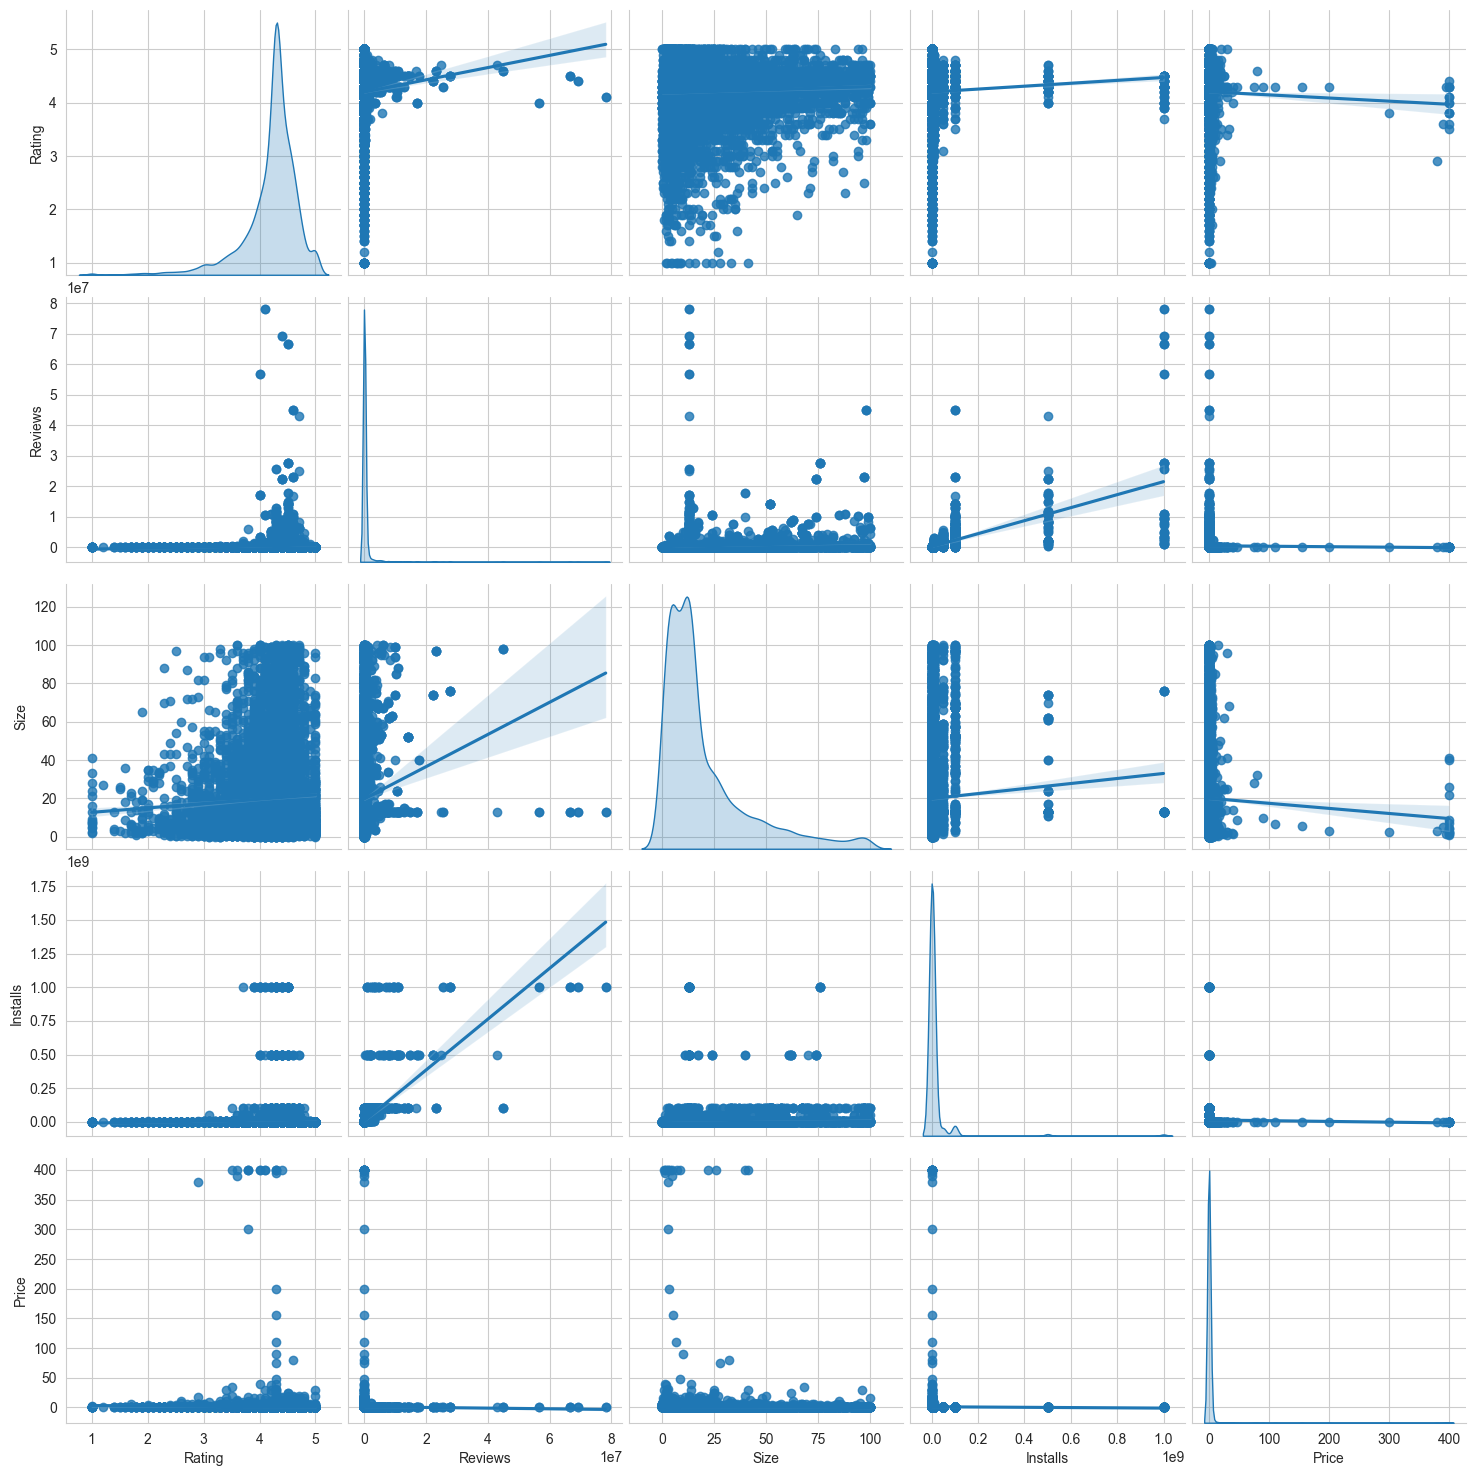

In [256]:
sns.set_style("whitegrid")
sns.pairplot(df,diag_kind='kde', kind='reg',height=3)
plt.show()

Vado un po' più a fondo alle correlazioni tramite questo pairplot, anche se le scale di valori sono molto diverse tra loro cerchiamo di ricavare più informazioni possibile:  
Viene confermata la correlazione positiva tra 'Installs' e 'Reviews', si può però dire che la concentrazione dei valori è sui valori bassi (come si può notare anche dalle distribuzioni) quindi poche installazioni corrisponde a poche recensioni il che è molto logico.  
In maniera molto leggera per quanto riguarda il Rating sembrerebbe che con l'aumentare di 'Reviews', 'Installs' e 'Size' aumenti anche il Rating, anche qui ricordiamo sempre le distribuzioni che possono essere "ingannevoli" ma comunque è un qualcosa da tenere a mente. Prezzi più bassi invece danno Rating più alto.  
Altri insights interessanti possono essere riguardo al 'Size', che ha una correlazione positiva con 'Reviews' ed 'Installs', e leggermente negativa invece con 'Price'.

In [257]:
#trasformo le variabili in "object" per renderle categoriche e quindi analizzabile tramite ANOVA
df['month'] = df['month'].astype("object")
df['Android_Ver'] = df['Android_Ver'].astype("object")

In [258]:
#faccio un test ANOVA per vedere come le variabili categoriche si relazionano al Rating, escludo Type perchè ha due soli valori
categorical_vars = ['Category', 'new_genres', 'Content_Rating', 'month','Android_Ver']

#esecuzione dell'ANOVA per ogni variabile categorica
for var in categorical_vars:
    grouped_data = df.groupby(var)['Rating'].apply(list)
    fvalue, pvalue = f_oneway(*grouped_data)
    print("{}: F-value = {:.2f}, p-value = {:.4f}".format(var, fvalue, pvalue))

Category: F-value = 7.94, p-value = 0.0000
new_genres: F-value = 6.23, p-value = 0.0000
Content_Rating: F-value = 4.37, p-value = 0.0006
month: F-value = 15.73, p-value = 0.0000
Android_Ver: F-value = 12.29, p-value = 0.0000


I risultati del Test ANOVA sulle variabili categoriche indicano ottimi risultati su tutte le variabili, che risultano quindi "correlate" al "Rating", considerando come si fa di norma una variabile correlata se ha un  p-value <0.05. L'F-Value invece più è alto meglio è, quindi "month" e "Android_Ver" hanno i valori migliori secondo il test ANOVA.

## 4. Machine Learning <a class="anchor" id="fourth-bullet"></a>

Adesso dopo l'analisi voglio provare a creare un modello che possa prevedere il Rating, così da immaginare che creando una nuova App io possa poi prevedere che Rating avrà, successivamente poi vedere anche le Feature Importances così da vedere quali variabili hanno più influenza sulla predizione del Rating. Ho scelto il modello Gradient Boosting, visto che il modello sembra avere diverse variabili sullo stesso livelli è meglio scegliere un modello più robusto rispetto a per esempio una regressione lineare.

### 4.1 Encoding variabili categoriche <a class="anchor" id="fourth1-bullet"></a>

In [259]:
#creo una copia del dataframe così da effettuare le trasformazioni alle variabili.
df1 = df.copy()

In [260]:
#alle colonne 'Category' e 'new_genres' scelgo LeaveOneOut perchè è una buona scelta quando si hanno molti valori unici
encoder = LeaveOneOutEncoder()
columns_to_encode = ['Category', 'new_genres']
df_encoded = encoder.fit_transform(df1[columns_to_encode], df1['Rating'])

df1 = pd.concat([df1, df_encoded.add_suffix('_loo')], axis=1)

In [261]:
#applico one-hot
cont = pd.get_dummies(df1['Content_Rating'], prefix='cont_')
mo = pd.get_dummies(df1['month'], prefix='mo_')
andr = pd.get_dummies(df1['Android_Ver'], prefix='andr_')

df1 = pd.concat([df1, cont,mo,andr], axis=1)

In [262]:
#su type basta labelencoder
le = LabelEncoder()
df1['Type'] = le.fit_transform(df1['Type'])

In [263]:
#trasformo la colonna 'Installs' applicando un logaritmo così da rendere su una scala più "comprensibile" i dati
df1['Installs']=np.log(df1['Installs'] + 1)

In [264]:
#elimino le colonne che ho trasformato
df1.drop(['App','Category','Content_Rating','new_genres','month','Android_Ver'],axis=1,inplace=True)

### 4.2 Modello Gradient Boosting <a class="anchor" id="fourth2-bullet"></a>

In [265]:
#divido il dataset in train e test e uso minmaxscaler per normalizzare
scaler = MinMaxScaler()
X = df1.loc[:, df1.columns != 'Rating']
y = df1['Rating']
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [266]:
#applico modello GradientBoostingRegressor
model = GradientBoostingRegressor(random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("RMSE using GB:", np.sqrt(mse))
print("R2 using GB:",r2)

RMSE using GB: 0.34201108889131837
R2 using GB: 0.497085357613566


Ho fatto una prima applicazione del modello senza toccare iperparametri, vediamo se riesco a migliorarla tramite tuning degli iperparametri.

In [ ]:
#tuning degli iperparametri
param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10]
}

scoring = make_scorer(mean_squared_error, greater_is_better=False)


grid_search = GridSearchCV(model, param_grid=param_grid, scoring=scoring, cv=5,n_jobs=-1,verbose=10)


grid_search.fit(X_train, y_train)


print('Best parameters:', grid_search.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits


In [ ]:
#applico il modello "potenziato" ai dati di test
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("RMSE using GB:", np.sqrt(mse))
print("R2 using GB:",r2)

Il risultato è migliorato molto, abbiamo un RMSE di 0.23, il che vuol dire che in media i valori predetti si discostano di 0.23 dal valore reale da predirre, e un R2 di 0.76 indica che il modello spiega il 76,1% della varianza dei dati, il che lo ritengo un risultato abbastanza buono.

In [ ]:
#predico anche i risultati sul train
y_train_pred = best_model.predict(X_train)

rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)
print("RMSE using GB on train set:", rmse_train)
print("R2 using GB on train set:", r2_train)

Le performance sul train sono ottime e probabilmente c'è un po' di overfitting, però che comunque non sono riuscito a risolvere tramite tuning degli iperparametri, lo ritengo accettabile perchè mi garantisce un buon risultato sul test.

In [ ]:
#mostro lo scatter plot degli errori
plt.scatter(y_test, y_pred)

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)

plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('True values vs predicted values')

plt.show()

Dallo scatterplot possiamo vedere come gli errori sono distribuiti, la maggior parte dei puntini si trova intorno alla linea il che è sintomo di poco errore, la maggior parte degli errori previsti male sono valori bassi che vengono previsti alti, questo perchè nei dati comunque erano pochi i valori di Rating sotto il 3.

In [ ]:
#dò un'occhiata alle learning curves
train_sizes, train_scores, test_scores = learning_curve(best_model, X_train, y_train, cv=5, n_jobs=-1, 
                                                        scoring='neg_mean_squared_error', shuffle=True)

train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = -np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(9,4))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='Training error')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation error')
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.15, color='green')
plt.xlabel('Number of training samples')
plt.ylabel('Error')
plt.legend(loc='upper right')
plt.show()

Le learning curves mostrano il validation error che va sempre a diminuire, mentre il training test è sempre stabile e va ad aumentare leggermente verso la fine il che dà la conferma di un leggero overfitting però comunque come detto prima ritengo accettabile.

### 4.3 Feature Importances <a class="anchor" id="fourth3-bullet"></a>

In [ ]:
#ricavo le feature importances e le metto in un dizionario
importances = best_model.feature_importances_
feature_names = df1.columns[df1.columns != 'Rating']
feature_importances = dict(zip(feature_names, importances))

In [ ]:
#sommo tutte le feature importances delle features che prima avevo diviso tramite one-hot
new_f_i = {'month': sum(value for key, value in feature_importances.items() if key.startswith('mo_')),
            'content_rating': sum(value for key, value in feature_importances.items() if key.startswith('cont_')),
            'android_version': sum(value for key, value in feature_importances.items() if key.startswith('andr_'))}

new_f_i.update({key: value for key, value in feature_importances.items() if not key.startswith('mo_') 
                 and not key.startswith('cont_') and not key.startswith('andr_')})

new_f_i = sorted(new_f_i.items(), key=lambda x: x[1], reverse=True)

In [ ]:
#plotto le feature importances
features = [x[0] for x in new_f_i]
importances = [x[1] for x in new_f_i]

plt.figure(figsize=(10, 6))
plt.bar(features, importances,color='#8A2BE2')
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

Dal grafico delle Feature Importances le variabili più importanti per la predizione risultano essere "Category" e "new_genres", c'è da dire che hanno subito un encoding diverso, comunque anche Reviews ed Installs sono variabili importanti; il tipo e il content_rating sono quelle meno importanti. I risultati sembrano essere leggermente diversi da quelli di ANOVA (ma neanche troppo) però comunque è importante tenere in considerazione tutto.

## 5. Conclusioni <a class="anchor" id="fifth-bullet"></a>

### 5.1 Conclusioni linee guida <a class="anchor" id="fifth1-bullet"></a>

Concludiamo da dove abbiamo iniziato, diamo risposta alle domande poste inizialmente:  
* **Quali sono le categorie (e generi) di App più rappresentate nell'App Store di Google? E quelle delle App migliori?**  

Le categorie più presenti nell'App Store di Google sono principalmente "Family", "Game", "Tools", "Business", "Medical" in quest'ordine. Considerando invece la selezione fatta di "App migliori" quindi con Rating >4.3, Installazioni >100000, Recensioni >1000, l'ordine è questo: "Game", "Family", "Tools", "Photography", "Productivity". In particolare i giochi "Arcade,puzzle ecc." e "Action e Adventure" sono presentissimi in catalogo. Agli ultimi posti in ordine sparso: "Beauty", "Parenting", "Comics", "Events", "Libraries and Demo".
* **App gratuita o a pagamento?**  

Diciamo che non c'è molta differenza di Rating tra App gratuite ed a pagamento, ma quelle gratuite sono installate sicuramente di più. Inoltre il numero di App gratuite presenti sullo store è infinite volte più alto di quelle a pagamento.
* **Prezzo e dimensione dell'App influiscono sul Rating?**  

Non sembrano influire troppo, ma generalmente un App di dimensioni grandi ha un rating alto, mentre un prezzo basso sembra leggermente portare Rating più alti, anche se vedendo bene le distribuzioni in realtà le App molto costose hanno quasi sempre un buon Rating, mentre quelle economiche possono oscillare su tutto il range.
* **Esiste un periodo migliore o peggiore per lanciare un'App (mese,anno)?**  

L'anno migliore sembra evidente che sia sempre l'ultimo disponibile, più è recente l'App e meglio è (ovviamente). Sul discorso del mese è particolare perchè c'è una netta prevalenza per i mesi di Luglio in particolare e anche Maggio e Agosto come mesi in cui vengono lanciate più App e tra l'altro App con Rating migliori. In particolare sul numero di App lanciate a settembre c'è un calo che mi fa ipotizzare che ci sia una certa "fretta" nello sviluppare le App prima di eventuali ferie ad Agosto, il che spiegherebbe il picco di Luglio e Agosto.
* **A che categoria è meglio rivolgere un'App?**  

È sicuramente preferibile realizzare app per tutto il pubblico, dalle analisi è la categoria più stabile considerando anche l'alto numero di App presenti nello store.

* **È possibile prevedere il Rating di un'app?**  

Il modello Gradient Boosting creato permette di prevedere il Rating con un errore di 0.23 che spiega circa il 76% dei dati, un buon risultato quindi che potrebbe permettere al lancio di una nuova App di riuscire a prevedere con una discreta precisione il Rating che avrà. C'è qualche errore in particolare sui Rating molto bassi ma con lo studio fatto con le varie analisi credo sia possibile evitarli.
* **Quali sono le variabili che determinano di più un Rating alto?**  

Qui la questione è complicata perchè dalle varie analisi (grafici, heatmap, anova, feature importances) sono venute fuori varie considerazioni, innanzitutto che nessuna variabile comunque risulta completamente inutile (a parte "Current Ver" che avevo eliminato all'inizio). Riunendo un po' il tutto sicuramente la Categoria e il genere possono avere un'influenza importante sul Rating ed è quindi bene sceglierle correttamente; il numero di recensioni ed installazioni sicuramente può influire sul Rating perchè ovviamente se si riesce ad avere un'app molto installata è anche molto probabile che sia ben recensita (anche se queste due sono cose che vengono dopo aver lanciato l'app). In generale comunque è bene quindi non sottovalutare nessun aspetto perchè qualsiasi cosa può influire sul Rating. Quello che non sembra influire sul rating è il tipo (se gratuita o a pagamento) di App.

### 5.2 Ipotesi lancio nuova App <a class="anchor" id="fifth2-bullet"></a>

Provo adesso a "giocare" ipotizzando di dover lanciare una nuova App, voglio fare tre ipotesi (tutte inventate):

**1. Heroes of the Lost Island**  
Si tratta di un gioco (essendo la seconda categoria più rappresentata e la miglior categoria considerando solo le migliori app), inoltre per qualsiasi tipo di analisi i giochi portano con buona probabilità buoni risultati, e in particolare ho scelto un gioco di avventura che era il sottegenere migliore considerando solo le App migliori. Il gioco lo creerei gratuito vista l'alta concorrenza ma metterei delle ulteriori funzionalità sbloccabili a pagamento. Il gioco è destinato a tutte le fasce d'età e tratta degli eroi con diversi poteri magici che si ritrovano su un'isola misteriosa di cui dovranno scoprirne i segreti. Essendo un gioco molto complicato con varie possibilità all'interno sarà un gioco pesante, all'incirca 100 mega, non un giochino passatempo.

**2. Casual Corner**  
Questo si tratta di un'applicazione più "leggera" in tutti i sensi, sia di peso (10 MB circa), sia di contenuto, infatti sarà un insieme di giochini semplici come puzzle, memory, giochi di carte, giochi senza troppo impegno. Anche questa un'applicazione per tutti, soprattutto da giocare in più persone magari in famiglia (quindi categoria "Family"). L'App sarà ovviamente gratuita, nessuno pagherebbe per qualcosa di simile.

**3. ProTasker**  
Sulla terza App decido di "rischiare" un po' scegliendo un'app sulla Produttività, che in questi ultimi anni stanno prendendo piede (e anche dall'analisi risultano ben piazzate su tutto ma non così in alto quindi probabilmente c'è spazio per inserirsi), sarà un'app in cui impostare promemoria e scadenze, creare elenchi di attività da realizzare in giornata o in periodi più lunghi, con anche la possibilità di assegnare attività ad altre persone (utile quindi anche per team di lavoro). Anche questa sarà un'App gratuita dal peso di circa 10 MB.